# Find the details of user registration

In [1]:
## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

import re # to access database details in a file
import time # to time how long queries and processes take
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta # to manipulate dates

from connect_db import connect_db

% matplotlib inline

In [2]:
path='/Users/brianna/Documents/WL_DBdeets/'

In [3]:
# Access the 'events' database.
conE, curE = connect_db('evnt', path)

# Access the 'transactions' database.
conT, curT = connect_db('trns', path)

I connected to the evnt database!!
I connected to the trns database!!


### Query the db for signup date and other information about participation

In [13]:
# Make a list of everyone who's signed up (AKA had a sign-up event)

starttime=time.time()

sql_query="""
    select 
        user_id, date_trunc('day',event_time)::DATE as reg_date, u_email
    from 
        app131567.signed_up
"""

query_result = pd.read_sql_query(sql_query,conE)

print(time.time()-starttime)

signups=query_result.iloc[:]
# Drop duplicated whole rows.
signups = signups.drop_duplicates(keep='first')

# If there are duplicated 
signups = signups.drop_duplicates(subset='user_id', keep='first')


0.547454118729


In [14]:
# Convert the registration date to a datetime object so that it can be binned by week.
def convert_to_datetime(x):
    return datetime.combine(x, datetime.min.time())

signups.reg_date = signups.reg_date.apply(lambda x: convert_to_datetime(x))

In [15]:
# Make a list of the weeks between 2015-05-24 and now.
weekList = []
date_start = datetime.strptime('2015-05-24', "%Y-%m-%d")
current_date = datetime.now()

while date_start < current_date + timedelta(days=7):
    weekList.append(date_start)
    date_start += timedelta(days=7)

# Make an identical list but filled with the string version of the variable instead of the 
# datetime version.  (We have to use the [:] notation or else both variable names point to
# the same object.)

weekStringList=weekList[:]
for w in range(len(weekStringList)):
    weekStringList[w]=str(weekStringList[w]).split(' ')[0]

In [16]:
# Make a column of the week they signed up (to get a metric that's the same as the transactional 
# data that I have collapsed into weekly bins)

date_start = datetime.strptime('2015-05-24', "%Y-%m-%d")
current_date = datetime.now()

signups['reg_week'] = current_date

while date_start < current_date:
    date_end = date_start + timedelta(days=7)
    #print(str(date_start)+' '+str(date_end))
    signups.reg_week[(signups.reg_date>date_start) & (signups.reg_date<date_end)]=date_start
    date_start += timedelta(days=7)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
signups.head()

,user_id,reg_date,u_email,reg_week
0,556ce8dc1407c9df346e54dc,2015-06-01,None,2015-05-31
1,556cf3dfb78b730beae27960,2015-06-02,None,2015-05-31
2,556cf8fa913df923867886bd,2015-06-02,None,2015-05-31
3,556d11ac6e81ef883374705b,2015-06-02,None,2015-05-31
4,556d397dc23812601a3bbcdf,2015-06-02,None,2015-05-31


In [9]:
# Add information on a few more types of events to the dataframe, 
# ie. how often the following things happen:
# - added_meeting
# - added_agenda_item
# - added_note
# - assigned_action_item

eventList = ['added_meeting','added_agenda_item','added_note','assigned_action_item','viewed_onboarding__tour_4_page']
starttime=time.time()

for event in eventList:
#event = eventList[0]
    print(event)
    for w in range(len(weekList)):
        week = weekList[w]
        end_date = week + timedelta(days=7)
        string1="select user_id from app131567.{event}".format(event=event)
        string2=" where lower(event_time) between  "
        string3 = " '{start_date}' and '{end_date}'".format(start_date = week, end_date = end_date)
        sql_query = string1 + string2 + string3

        query_result = pd.read_sql_query(sql_query,conE)

        # Make a column named with the name of the event that's all ones that we can
        # use later to sum and get aggregate numbers.
        columnName=event+weekStringList[w]
        columnName=columnName.replace('-','_')

        eventDF=query_result.iloc[:]
        eventDF[columnName]=1
        sumDF=eventDF.groupby('user_id').sum()

        if event == eventList[0] and w ==0:
            allEvts = sumDF
        else:
            allEvts = allEvts.join(sumDF, how = 'outer')
        #sumDF=eventDF.groupby('user_id').sum()

added_meeting
added_agenda_item
added_note
assigned_action_item
viewed_onboarding__tour_4_page


In [10]:
# Combine all of the entries in allEvts with the signups dataframe
signups=signups.join(allEvts, on='user_id',how='right')

In [11]:
signups.to_csv(path+'UserRegistrationDateMoreDetails.csv')

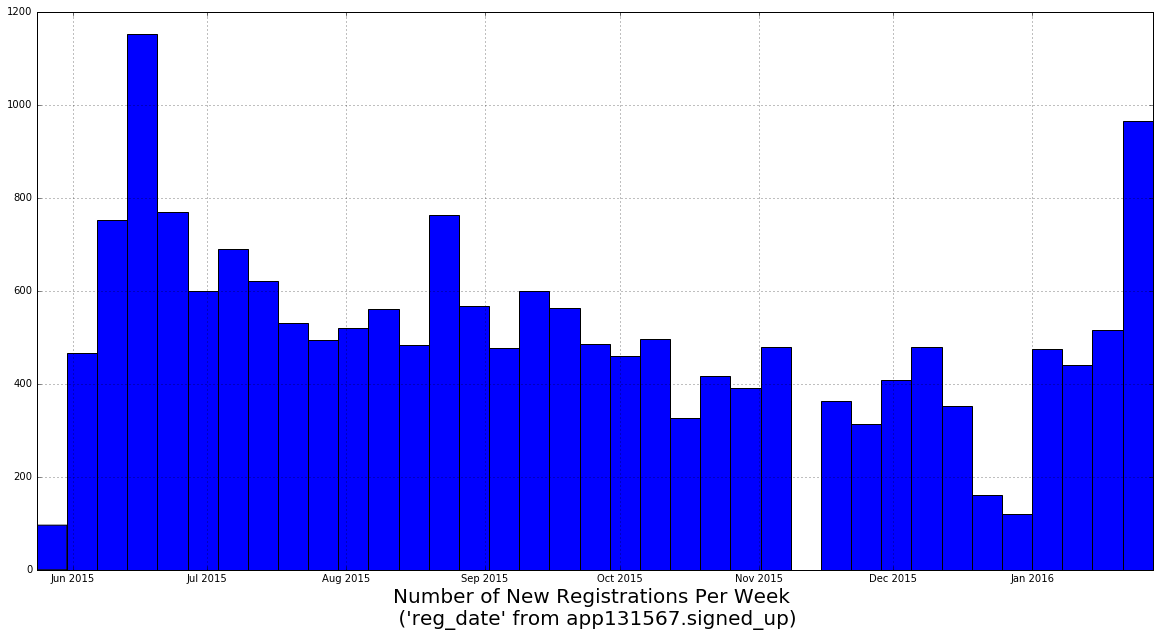

In [18]:
plt.figure(figsize=(20,10))
signups['reg_week'].hist(bins = len(signups['reg_week'].unique()))

plt.xlabel('Number of New Registrations Per Week \n (\'reg_date\' from app131567.signed_up)', size=20)

# Find whether each person has connected their calendar.